<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Yevin/Copy_of_pre_requirements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-prediction-dataset


In [20]:
!pip install -q imbalanced-learn joblib pandas scikit-learn

In [39]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [40]:
# Load dataset
df = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
print(df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [41]:
df.shape

(100000, 9)

In [42]:
print(df.info())  # Data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


In [43]:
print(df.describe()) # Summary stats for numerical columns

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

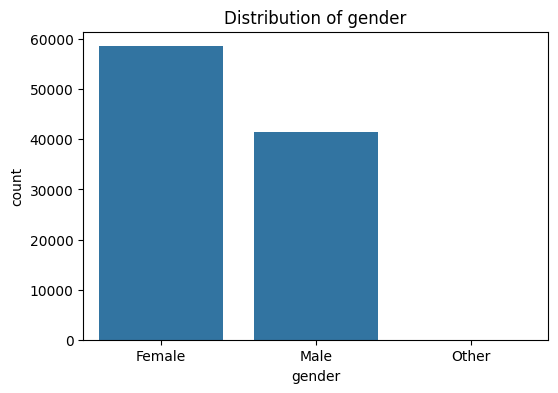

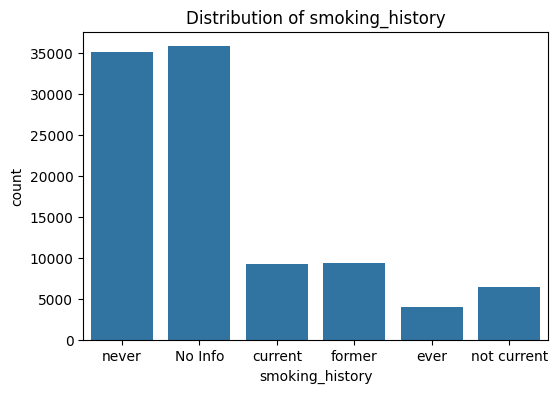

In [44]:
# Visualize categorical features
categorical_features = ['gender','smoking_history']
for feature in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()

/tmp/ipython-input-1187025268.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diabetes', data=df, palette='viridis')


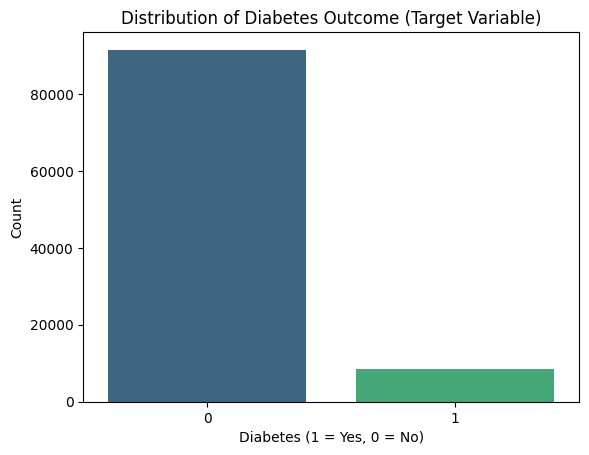

In [45]:
# Count of diabetic (1) vs non-diabetic (0)
sns.countplot(x='diabetes', data=df, palette='viridis')
plt.title('Distribution of Diabetes Outcome (Target Variable)')
plt.xlabel('Diabetes (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [46]:
df['diabetes'].value_counts(normalize=True)

,proportion
diabetes,
0,0.915
1,0.085


In [47]:
duplicates = df.duplicated().sum()
print("Duplicate Rows:", duplicates)

Duplicate Rows: 3854


In [48]:
#Remove duplicates
df = df.drop_duplicates()
print("New Shape:", df.shape)

New Shape: (96146, 9)


In [49]:
df['smoking_history'].isnull().sum()

np.int64(0)

In [50]:
# Identify categorical and continuous cols
# Adjust these lists if you have different column names
possible_cat = ['gender', 'smoking_history']
all_cols = df.columns.tolist()
all_cols.remove('diabetes')
cat_cols = [c for c in possible_cat if c in df.columns]
cont_cols = [c for c in all_cols if c not in cat_cols]


print('Categorical cols:', cat_cols)
print('Continuous cols:', cont_cols)

Categorical cols: ['gender', 'smoking_history']
Continuous cols: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [51]:
# Handle missing values: simple strategy (modify as needed)
for c in cont_cols:
  if df[c].isnull().any():
    df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
  if df[c].isnull().any():
    df[c].fillna(df[c].mode()[0], inplace=True)


In [52]:
#Clip extreme outliers for selected continuous features
for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
  if col in df.columns:
    df[col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))



In [53]:
# Encode categorical features as integer indices (LabelEncoder) - keep as integers (not one-hot)
encoders = {}
for c in cat_cols:
  le = LabelEncoder()
  df[c] = le.fit_transform(df[c].astype(str))
  encoders[c] = le

In [54]:
# Scale only continuous columns
scaler = StandardScaler()
df[cont_cols] = scaler.fit_transform(df[cont_cols])

In [55]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory to save to in Google Drive
DRIVE_OUT = '/content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs'

# Create the directory if it doesn't exist
os.makedirs(DRIVE_OUT, exist_ok=True)

# Save the encoder for later use
joblib.dump(encoders, os.path.join(DRIVE_OUT, 'label_encoder.pkl'))

Mounted at /content/drive


['/content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs/label_encoder.pkl']

In [56]:
# Save the scaler
joblib.dump(scaler, os.path.join(DRIVE_OUT, "scaler.pkl"))

['/content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs/scaler.pkl']

In [57]:
# Apply SMOTE on training split later - but we will apply SMOTE on full data then split to avoid leaking labels.
X = df.drop('diabetes', axis=1)
y = df['diabetes']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print('After SMOTE shape:', X_res.shape, y_res.shape)

After SMOTE shape: (175328, 8) (175328,)


In [58]:
# Recreate dataframe
df_res = pd.DataFrame(X_res, columns=X.columns)
df_res['diabetes'] = y_res

In [59]:
# Train/test split
train_df, test_df = train_test_split(df_res, test_size=0.2, random_state=42, stratify=df_res['diabetes'])


In [60]:
# Save
train_csv = os.path.join(DRIVE_OUT, 'clean_data_train.csv')
test_csv = os.path.join(DRIVE_OUT, 'clean_data_test.csv')
meta_pkl = os.path.join(DRIVE_OUT, 'meta_info.pkl')


train_df.to_csv(train_csv, index=False)
test_df.to_csv(test_csv, index=False)


meta = {'cat_cols': cat_cols, 'cont_cols': cont_cols, 'target_col': 'diabetes'}
joblib.dump(meta, meta_pkl)


print('Saved:')
print(' -', train_csv)
print(' -', test_csv)
print(' -', meta_pkl)

Saved:
 - /content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs/clean_data_train.csv
 - /content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs/clean_data_test.csv
 - /content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs/meta_info.pkl


/tmp/ipython-input-4144245664.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diabetes', data=df, palette='viridis')
/tmp/ipython-input-4144245664.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diabetes', data=df_res, palette='viridis')


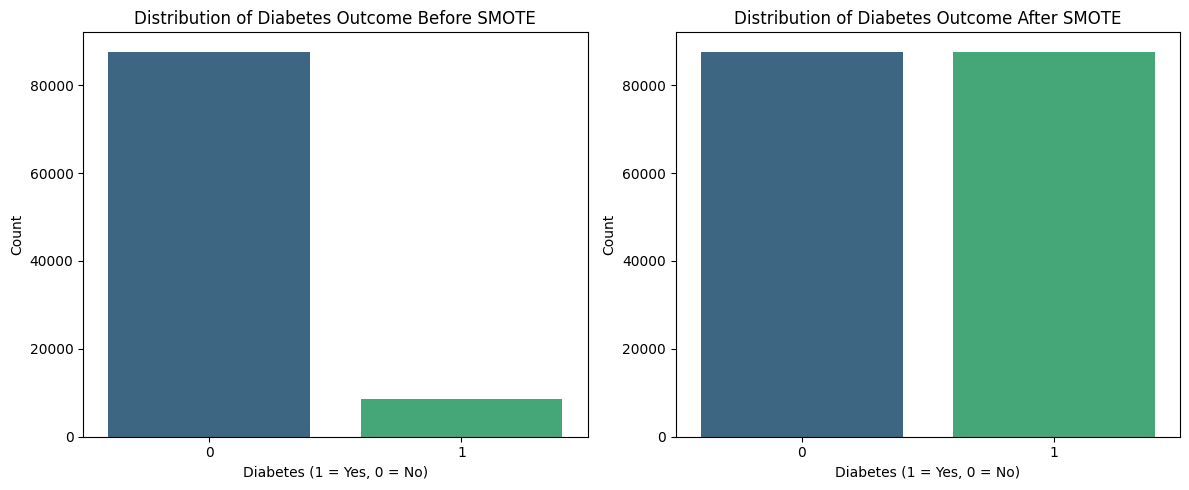

In [61]:


# Plot distribution before SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='diabetes', data=df, palette='viridis')
plt.title('Distribution of Diabetes Outcome Before SMOTE')
plt.xlabel('Diabetes (1 = Yes, 0 = No)')
plt.ylabel('Count')

# Plot distribution after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x='diabetes', data=df_res, palette='viridis')
plt.title('Distribution of Diabetes Outcome After SMOTE')
plt.xlabel('Diabetes (1 = Yes, 0 = No)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()